# Python Scraper For E Aim
This program can scrape the form of a particular E-AIM page and fill it in using user defined parameters. This allows for the insertion of E-AIM directly into code. Note that invalid inputs are not handled by this program. The basic flow is: open session, get page form, fill in a dictionary with form data, post the data, save the response and convert the response to csv files.


This box contains functions for scraping the forms from the url.

In [4]:
from bs4 import BeautifulSoup
from requests_html import HTMLSession
from pprint import pprint
from urllib.parse import urljoin
import webbrowser
import sys
import csv

session = HTMLSession()
def get_all_forms(url):
    """Returns all form tags found on a web page's `url` """
    # GET request
    res = session.get(url)
    # for javascript driven website
    # res.html.render()
    soup = BeautifulSoup(res.html.html, "html.parser")
    return soup.find_all("form")


def get_form_details(form):
    """Returns the HTML details of a form,
    including action, method and list of form controls (inputs, etc)"""
    details = {}
    # get the form action (requested URL)
    action = form.attrs.get("action")
    if action:
        action = action.lower()
    # get the form method (POST, GET, DELETE, etc)
    # if not specified, GET is the default in HTML
    method = form.attrs.get("method", "get").lower()
    # get all form inputs
    inputs = []
    for input_tag in form.find_all("input"):
        # get type of input form control
        input_type = input_tag.attrs.get("type", "text")
        # get name attribute
        input_name = input_tag.attrs.get("name")
        # get the default value of that input tag
        input_value =input_tag.attrs.get("value", "")
        # add everything to that list
        inputs.append({"type": input_type, "name": input_name, "value": input_value})
    for select in form.find_all("select"):
        # get the name attribute
        select_name = select.attrs.get("name")
        # set the type as select
        select_type = "select"
        select_options = []
        # the default select value
        select_default_value = ""
        # iterate over options and get the value of each
        for select_option in select.find_all("option"):
            # get the option value used to submit the form
            option_value = select_option.attrs.get("value")
            if option_value:
                select_options.append(option_value)
                if select_option.attrs.get("selected"):
                    # if 'selected' attribute is set, set this option as default    
                    select_default_value = option_value
        if not select_default_value and select_options:
            # if the default is not set, and there are options, take the first option as default
            select_default_value = select_options[0]
        # add the select to the inputs list
        inputs.append({"type": select_type, "name": select_name, "values": select_options, "value": select_default_value})
    for textarea in form.find_all("textarea"):
        # get the name attribute
        textarea_name = textarea.attrs.get("name")
        # set the type as textarea
        textarea_type = "textarea"
        # get the textarea value
        textarea_value = textarea.attrs.get("value", "")
        # add the textarea to the inputs list
        inputs.append({"type": textarea_type, "name": textarea_name, "value": textarea_value})
        
    # put everything to the resulting dictionary
    details["action"] = action
    details["method"] = method
    details["inputs"] = inputs
    return details

# Accessing a URL

This box is where the URL is accessed and the forms found. All E-Aim pages only have one form, so that is assumed in the rest of the code.

In [6]:
# get the URL from the command line
url = "https://www.aim.env.uea.ac.uk/aim/model3/model3d.php"
all_forms = get_all_forms(url)
#get the first form (edit this as you wish)
# extract all form details
form_details = get_form_details(all_forms[0])

# Filling in a form
This box contains functions that allow for creating prompts to insert into E-Aims batch mode. If running E-Aim a lot, it is recomended to compile your requests (max 100 per session) into a list, encoding them, then joining them using a new lines byte code (b'\r\n'). Currently only Model 3 is working, to use Model 4, use the inputs page of model 4 and create your own input parser with this template.

In [8]:
def model_three_RH_prompt(RH,water_dissociate=0,H=0,NH4=0,Na=0,SO4=0,NO3=0,Cl=0,Br=0,OH=0,NH3=0,form_HNO3=False,form_HCl=False,form_NH3=False,form_H2SO4=False,form_HBr=False,dont_form_solids=[]):
    a=298.15
    b=1
    c=1
    d=1
    e=water_dissociate
    f=RH
    g=H
    h=NH4
    i=Na
    j=SO4
    k=NO3
    l=Cl
    m=Br
    n=OH
    o=NH3
    p=0 if form_HNO3 else 3
    q=0 if form_HCl else 3
    r=0 if form_NH3 else 3
    s=0 if form_H2SO4 else 3
    t=0 if form_HBr else 3
    u=model_3_parse_solids(dont_form_solids)
    return f"{a} {b} {c} {d} {e} {f} {g} {h} {i} {j} {k} {l} {m} {n} {o} {p} {q} {e} {s} {t} {u}"

def model_three_total_water_prompt(moles_of_water,water_dissociate=0,H=0,NH4=0,Na=0,SO4=0,NO3=0,Cl=0,Br=0,OH=0,NH3=0,form_HNO3=False,form_HCl=False,form_NH3=False,form_H2SO4=False,form_HBr=False,dont_form_solids=[]):
    a=298.15
    b=1
    c=1
    d=2
    e=water_dissociate
    f=moles_of_water
    g=H
    h=NH4
    i=Na
    j=SO4
    k=NO3
    l=Cl
    m=Br
    n=OH
    o=NH3
    p=0 if form_HNO3 else 3
    q=0 if form_HCl else 3
    r=0 if form_NH3 else 3
    s=0 if form_H2SO4 else 3
    t=0 if form_HBr else 3
    u=parse_solids(dont_form_solids)
    return f"{a} {b} {c} {d} {e} {f} {g} {h} {i} {j} {k} {l} {m} {n} {o} {p} {q} {e} {s} {t} {u}"

def model_3_parse_solids(solids):
    indexes = {"(NH4)2SO4":10,
               "(NH4)3H(SO4)2":11,
               "NH4HSO4":12,
               "NH4NO3":13,
               "2NH4NO3 (NH4)2SO4":14,
               "2NH4NO3 (NH4)2SO4":15,
               "NH4NO3 NH4HSO4":16,
               "NH4Cl":17,
               "Na2SO4":18,
               "Na2SO4 10H2O":19,
               "Na3H(SO4)2":20,
               "NaHSO4 H2O":21,
               "NaHSO4":22,
               "NaH3(SO4)2 H2O":23,
               "Na2SO4 (NH4)2SO4 4H2O": 24,
               "NaNO3":25,
               "NaNO3 Na2SO4 H2O":26,
               "NaCl":27}
               
    
    result = f"{str(len(solids))} "
    for solid in solids:
        result += f"{indexes[solid]} 4 "
    return result

# REQUIRED INPUT: Filling in the form

This box details a usage for varying the RH over 100 values from 0.1 to 0.99. 'tf' is the text field of the batch page (found using the above box). Vary the ions in solution using the optional arguments found in the above box and add any undesired solids to "dont_form_solids".

In [12]:
import numpy as np
RH = np.linspace(0.10,0.99,100)
prompts = []
for H in RH:
    string = model_three_RH_prompt(H,NH4=2,SO4=1,dont_form_solids=["(NH4)2SO4"])
    bytes = string.encode()
    prompts.append(bytes)
final_prompt = b'\r\n'.join(prompts)
data = {'wwwInputMode': 'batch', #Hidden
        'parametric_page': '/aim/model3/model3d.php', #Hidden
        'Model': 'ModelIII', #Hidden
        'iCaseInorg': '1', #Hidden
        'ExcludeWater': 'y', #Hidden
        'OrgFileName': 'nullname', #Hidden
        'wwwOutputMode': 'column', #Top radio buttons
        None: 'Manage Compounds', #Not yet usable
        'nCompounds': '0', #Not yet usable
        'tf': final_prompt} #Text entry box

# Form Submission
This box submits the form to the site and saves the resulting page in html format as "page.html".

In [14]:
# join the url with the action (form request URL)
url = urljoin(url, form_details["action"])
# pprint(data)
if form_details["method"] == "post":
    print("posting")
    res = session.post(url, data=data)
elif form_details["method"] == "get":
    print("getting")
    res = session.get(url, params=data) 
    
# the below code is only for replacing relative URLs to absolute ones
soup = BeautifulSoup(res.content, "html.parser")
for link in soup.find_all("link"):
    try:
        link.attrs["href"] = urljoin(url, link.attrs["href"])
    except:
        pass
for script in soup.find_all("script"):
    try:
        script.attrs["src"] = urljoin(url, script.attrs["src"])
    except:
        pass
for img in soup.find_all("img"):
    try:
        img.attrs["src"] = urljoin(url, img.attrs["src"])
    except:
        pass
for a in soup.find_all("a"):
    try:
        a.attrs["href"] = urljoin(url, a.attrs["href"])
    except:
        pass

# write the page content to a file
open("page.html", "w").write(str(soup))

posting


65790

# Reading output as a csv
This function takes the html and, for a model 3 batch calculation in column mode, saves 3 csvs containing the data outputted by the model over the inputs. 

In [43]:
#Save the webpage as "page.html" and this will convert the 3 tables into 3 csv files
import numpy as np
from bs4 import BeautifulSoup
from requests_html import HTMLSession
from pprint import pprint
from urllib.parse import urljoin
import webbrowser
import sys
import csv
def convert_html_to_tables(file_name):
    html = open("page.html").read()
    soup = BeautifulSoup(html, features="html.parser")
    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out
    text = soup.get_text()
    # break into lines and remove leading and trailing space on each
    lines = list(line.strip() for line in text.splitlines())
    lines = [line for line in lines if line]
    table = -1
    tables = [[],[],[]]
    for line in lines:
        if "---" in line:
            continue
        if "Column" in line:
            table += 1
        elif table >= 0:
            result = line.split()
            if result[1] == "iFail":
                result.pop(2)
            if result[2] == "P":
                result.pop(2)
            if not result[0].isdigit():
                size = len(result)
            if len(result) != size:
                if table == 0:
                    result += [0,0,0,0]
                elif table == 1:
                    result.insert(1,0)
                    result.insert(1,0)
            if result[0] == "The":
                break
            tables[table] += [result]
            
    with open("table1.csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(tables[0])
    
    with open("table2.csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(tables[1])
    
    with open("table3.csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(tables[2])

convert_html_to_tables("page.html")


Take the 3 previous tables and merge them into one large table, removing redundant data. 

In [65]:
import pandas as pd

def merge_tables(name):
    df1 = pd.read_csv("table1.csv")
    df2 = pd.read_csv("table2.csv")
    df3 = pd.read_csv("table3.csv")
    
    df1 = df1.set_index("I")
    df2 = df2.set_index("I")
    df3 = df3.set_index("I")
    df = pd.concat([df1,df2,df3],axis=1)
    df.to_csv(name, sep=",")
    

merge_tables("(NH4)2SO4.csv")

# Applying fits to data
Solution definitions require fits of mass fraction of solute against both solution activity (equlibrium RH) and solution density. For density, the usual fit is against the square root of the mass fraction of solute.

In [73]:
df = pd.read_csv("(NH4)2SO4.csv")

In E-aim, there is always one mole of salt in the solution so the mass of solute is just the molar mass of the salt in kg/mol

In [82]:
RH = df["RH"]
density = df["Density(aq)"] * 1e3 #kg/m3 = g/L

solute_mass = 132.1395 * 1e-3 #kg
water_mass = df["n_H2O(aq)"]*18.02*1e-3 #kg
mfs = solute_mass/(water_mass+solute_mass)
mfs

0     0.961236
1     0.955045
2     0.948275
3     0.940981
4     0.933263
        ...   
95    0.154240
96    0.126079
97    0.096202
98    0.064969
99    0.033145
Name: n_H2O(aq), Length: 100, dtype: float64

In [98]:
mfs_density_fit = np.polyfit(np.sqrt(mfs),density,5)
mfs_activity_fit = np.polyfit(mfs,RH,7)

Text(0.5, 1.0, 'Density Fitting')

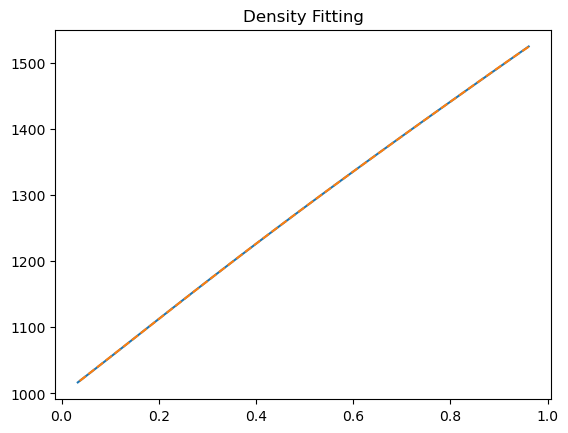

In [100]:
import matplotlib.pyplot as plt
plt.plot(mfs,np.poly1d(mfs_density_fit)(np.sqrt(mfs)))
plt.plot(mfs,density,"--")
plt.title("Density Fitting")

Text(0.5, 1.0, 'Activity Fitting')

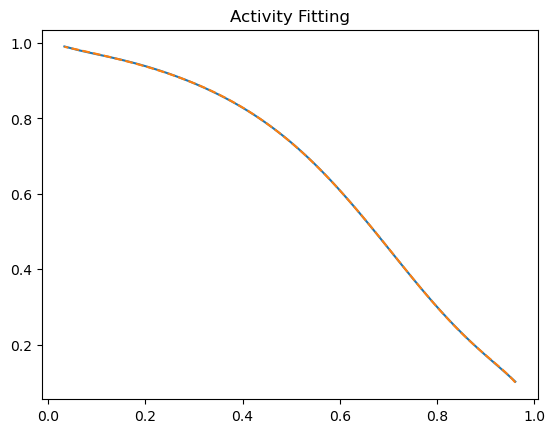

In [104]:
plt.plot(mfs,np.poly1d(mfs_activity_fit)(mfs))
plt.plot(mfs,RH,"--")
plt.title("Activity Fitting")

In [106]:
print(mfs_activity_fit)
print(mfs_density_fit)

[ -28.15630782   88.73404482 -107.41329752   65.17689412  -22.50820346
    3.77943941   -0.56985704    1.00629711]
[ 226.25500764 -608.16739502  491.53895936  421.04298406   16.65801575
  997.3889799 ]
